In [31]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import CrossEncoder, util, SentenceTransformer

In [32]:
embeddings_location = 'page-embeddings-selected.pkl'

print("Loading pre-computed embeddings from disc: " + embeddings_location)
with open(embeddings_location, "rb") as reader:
    cache_data = pickle.load(reader)
    sections = cache_data['sections']
    corpus_embeddings = cache_data['embeddings']

print('Corpus embeddings loaded.')
print('Corpus embedding size:', corpus_embeddings.shape)

Loading pre-computed embeddings from disc: page-embeddings-selected.pkl
Corpus embeddings loaded.
Corpus embedding size: (5978, 384)


In [33]:
df_sections = pd.DataFrame.from_records(pd.json_normalize(sections, sep='_'))
df_sections['newlines'] = df_sections['content'].str.count('\n')
df_sections['whitespace'] = df_sections['content'].str.count(' ')
df_sections['special_chars'] = df_sections['content'].replace('\n', ' ').str.count('[^a-zA-Z0-9 ]')

In [34]:
df_long_sections = df_sections[
    (df_sections['tokens'].isna() |
    df_sections['tokens'].gt(250)) &
    df_sections['newlines'].gt(3) &
    df_sections['newlines'].lt(16) &
    df_sections['whitespace'].gt(120)
].drop_duplicates(subset=['content'])

df_long_section_ids = df_long_sections.index

numpy_sections = np.array(sections)
numpy_embeddings = np.array(corpus_embeddings)

selected_sections = numpy_sections[df_long_section_ids]
selected_embeddingns = numpy_embeddings[df_long_section_ids]


In [24]:
with open('page-embeddings-selected.pkl', "wb") as writer:
    pickle.dump({'sections': selected_sections, 'embeddings': selected_embeddingns}, writer)

In [35]:
df_long_sections
print(len(df_long_sections))
pd.set_option('display.max_colwidth', None)
df_long_sections[['content', 'whitespace', 'newlines', 'special_chars']].sample(10)

5978


,content,whitespace,newlines,special_chars
2555,"Animation Format\nDo: Use video clips that the user can press to start and pause for non interactive animations that exist to provide supplementary information. \nUse animations created with SVGs that are coded using CSS and Javascript as they are scalable across multiple screen sizes, support prefers-reduced-motion on browser level settings and provide control over playing animated content for developers as well as end users\nSorry, your browser doesn't support HTML5 video. Here is a link to the video instead.\nA loading circle made up of five smaller circles animates on screen along with the text “loading.” The loading circle and text fade away briefly, then return with updated text that says “Almost there.”Don't: Use gifs that are on a constant loop.\nA gif of a loading circle made up of five smaller circles.## Using Animation to Inform the User\nDo: Include additional static elements to convey the same information as the animation (ie. text, icons, etc).",151,6,35
4903,"Snapshots\nPreviously in a SvelteKit app, if you navigated away after starting to fill out a form, going back wouldn’t restore your form state – the form would be recreated with its default values. Depending on the context, this can be frustrating for users. Since SvelteKit 1.5, we have a built-in way to address this: snapshots.\nNow, you can export a snapshot object from a +page.svelte or +layout.svelte. This object has two methods: capture and restore. The capture function defines what state you want to store when the user leaves the page. SvelteKit will then associate that state with the current history entry. If the user navigates back to the page, the restore function will be called with the state you previously had set.\nFor example, here is how you would capture and restore the value of a textarea:\n\n import type { Snapshot } from './$types';\n\n let comment = '';\n\n export const snapshot: Snapshot = {\n capture: () => comment,\n restore: (value) => (comment = value)\n };\n",163,13,70
4705,"Set positive expectations#\nUsing a button label of “Open in browser” sets the expectation that linked content will not be shown in the same view, in-app. But, research has shown that going to a browser window from an app — as well as that button label phrasing — is demotivating and reduces engagement. When it’s necessary to send someone away from an app, tell them as much without explicitly talking about the medium of where the content will appear.\nWhen someone completes a tour or tutorial, prioritize the next actions that will take them back to the home view to try more tutorials on another subject, or to the next one in the series.\nAvoid explicit web- or browser-based language such as: open in browser, view on the web, view online\nInstead, try subtler approaches: go to, play video, check it out, find out more, back to Learn, back to in-app tutorials, all tutorials on {subject}\nUse “go to” to imply that a user will be leaving their current experience.\nDon’t use “open in browser” as a call-to-action.",171,6,47
1678,"Do you have the necessary time and energy to contribute?\nWe all have a limited amount of time and energy. Before choosing your conflict management style, try to estimate the extent to which your personal resources will be drained when trying to resolve the issue. Entering situations of conflict can turn into a long ordeal that demands research, metrics, discussions, and a lot of stress. Make sure that you care enough about the issue to dedicate time and energy to it, as it can be exhausting and will impact your other tasks. Choose your priorities and decide if resolving this conflict is one of them.\nIs it possible to find the middle ground?\nIs it possible to see the other side of the argument? Is there a way of satisfying both parties? Or are your views polar opposites? Searching for a compromise when there’s none to be found is a waste of time. This question is easier to answer if you know yo

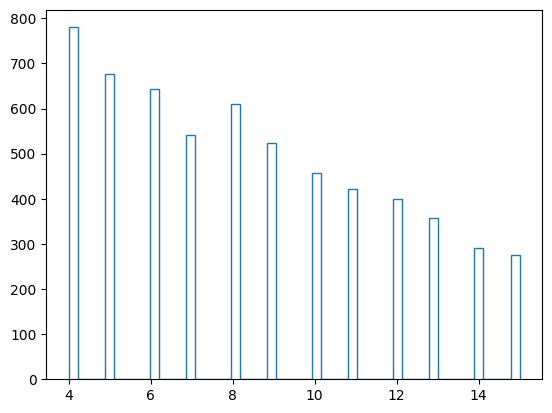

In [36]:
plt_range = [df_long_sections['newlines'].min(), df_long_sections['newlines'].max()]

counts, bins = np.histogram(df_long_sections['newlines'], range=plt_range, bins=50)
diagram = plt.stairs(counts, bins)

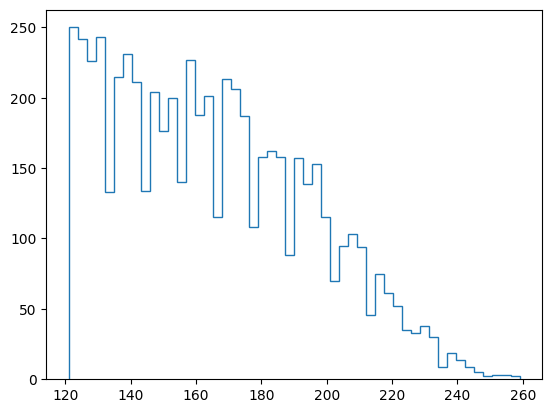

In [37]:
plt_range = [df_long_sections['whitespace'].min(), df_long_sections['whitespace'].max()]

counts, bins = np.histogram(df_long_sections['whitespace'], range=plt_range, bins=50)
diagram = plt.stairs(counts, bins)

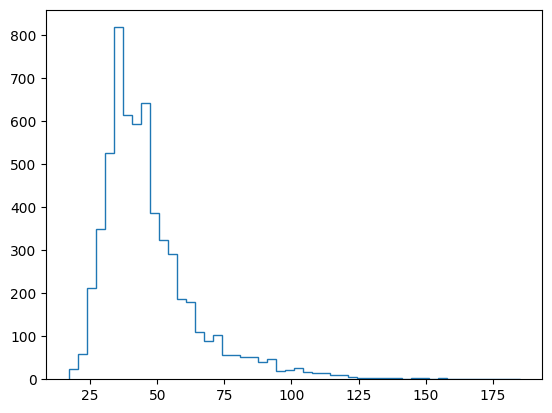

In [38]:
plt_range = [df_long_sections['special_chars'].min(), df_long_sections['special_chars'].max()]

counts, bins = np.histogram(df_long_sections['special_chars'], range=plt_range, bins=50)
diagram = plt.stairs(counts, bins)

In [39]:
bi_encoder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
bi_encoder.max_seq_length = 256

top_k = 32
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def getSectionContent(section):
    return section['content'].replace('\n', ' ').strip()

passages = []
passages.extend(map(getSectionContent, sections))

def search(query):
    print("Input question:", query)

    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    # Change back to .cuda() when GPU is available on Codespace
    question_embedding = question_embedding.cpu()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]

    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    print("\n-------------------------\n")
    print("Top-5 Cross-Encoder Re-ranker hits")
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['cross-score'], passages[hit['corpus_id']].replace("\n", " ")))

In [40]:
search('What is a Design System?')

Input question: What is a Design System?

-------------------------

Top-5 Cross-Encoder Re-ranker hits
	10.865	What is a design system? A design system is the source of truth, governing principles, and componentized delivery of design artifacts that repeatedly solves commonly recurring problems across an organization. This might be a mouthful of a definition, but there’s a reason for that. If you go around asking people “what exactly is a design system?” you’ll get different answers from everyone. To prove a point, I asked around our own team of dedicated design system professionals, and here are a couple of their definitions: “Repeatable solutions for commonly recurring problems” “A collection of design artifacts, and connection between design and developers” “Componentized delivery of designs, not just a style guide” Even if you search on Google, you’ll find equally different answers. But the thing is, none of them are wrong, design systems are all of these definitions combined. The

In [41]:
search('Who is Brad Frost?')

Input question: Who is Brad Frost?

-------------------------

Top-5 Cross-Encoder Re-ranker hits
	7.309	Hey there!   I'm Brad Frost, a design system consultant, web designer, speaker, writer, and musician located in beautiful Pittsburgh, PA. *  * ### Atomic Design I wrote a book called Atomic Design, which covers all that goes into creating and maintaining effective design systems. You can read it online and  order the ebook. *  * [### Wanna work together? I'm a principal and technical strategist at Big Medium, where we help teams establish and evolve design systems, establish more collaborative workflows, and create better software together. Need design system help? Need help leveling up your organization's digital practice? Get in touch!](/work) * [### Blog I write about web design best practices, design systems, responsive design, and other tasty topics on my blog. I also enjoy sharing and commenting on interesting links from around the web.](/blog) * [### Contact
	5.425	I dunno | 

In [45]:
search('How can you ensure Accessibility?')

Input question: How can you ensure Accessibility?

-------------------------

Top-5 Cross-Encoder Re-ranker hits
	4.686	Accessibility Ensure that view more/less is operable by keyboard Users should be able to select the component by pressing tab and enter to expand or contract. The space bar can also be used to toggle the more/less link between open and closed. WCAG 2.1: 2.1.3 Keyboard (No Exception) View more/less labels should be clear, concise, and accurately descriptive Any content which has been hidden within a view more/less should be obvious from the label alone, such as “Warranty details.” WCAG 2.1: 1.3.1 Info and Relationships Any lists with items hidden with view more/less should make the total items obvious from the outset Hiding list items is discouraged in general, as it can be misleading. If you need to hide list items, make sure the total number of items is stated clearly up front (either with a heading, or in the immediately preceding text) so people understand that the